# DM - Data understanding [TASK 1.1]

Exploring the dataset with analytical tool.

Library imports and initial settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from sklearn.decomposition import PCA

import sys
import logging as lg
import os

from utils import store_preprocessed_dataset, fetch_preprocessed_dataset, build_grid_plot
from utils.validators import check_bot, check_date, check_int, check_positive_int, check_text, MAX_DATE, MIN_DATE


root = lg.getLogger()
root.setLevel(lg.INFO)


nb_workers = int(os.cpu_count() / 2 + 1)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)
pandarallel.initialize(
    progress_bar=True,
    nb_workers=nb_workers,
)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Fetching the dataset using our native python functions.

In [2]:
from utils import fetch_dataset

dataset = fetch_dataset()

2022-11-05 10:57:17,632 - root - INFO - Pandas reading dataset tweets.csv...
2022-11-05 10:57:50,483 - root - INFO - Pandas reading dataset users.csv...


## Overview

### Users

Show `users.csv` information: types of data and columns.

In [3]:
users = dataset['users.csv'].copy() # make a copy

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11508 non-null  int64  
 1   name            11507 non-null  object 
 2   lang            11508 non-null  object 
 3   bot             11508 non-null  int64  
 4   created_at      11508 non-null  object 
 5   statuses_count  11109 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 539.6+ KB


Display lang values.

In [4]:
users['lang'].value_counts()

en                    9970
it                     906
es                     319
pt                      65
en-gb                   50
ru                      42
fr                      36
ja                      33
zh-tw                   17
tr                      14
id                      12
ko                       9
de                       8
nl                       6
en-GB                    4
ar                       3
zh-TW                    3
da                       2
Select Language...       2
en-AU                    1
zh-cn                    1
pl                       1
el                       1
fil                      1
sv                       1
xx-lc                    1
Name: lang, dtype: int64

As we can see, we have:

1. `xx-lc`
2. `Select Language...`

That are not a valid language.
We have decided to use iso639-1 Python library to detect valid languages.

Display BOT values
- 0 -> it's a user (human)!
- 1 -> it's a bot!

In [5]:
users['bot'].value_counts()

1    6116
0    5392
Name: bot, dtype: int64

As we can see we have clean data for `bot` column.

### Tweets

Show `tweets.csv` information: types of data and columns.

In [6]:
tweets = dataset['tweets.csv'].copy()

tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13664696 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   user_id         object
 2   retweet_count   object
 3   reply_count     object
 4   favorite_count  object
 5   num_hashtags    object
 6   num_urls        object
 7   num_mentions    object
 8   created_at      object
 9   text            object
dtypes: object(10)
memory usage: 1.0+ GB


## Quality assessment and data cleaning

In these cells we are going to understand and clean the data of two datasets.
The analysis performs:
1. Deletion of rows that has a ratio between valid values and invalid values `> k` where `k` is a param with default value 30%.
2. Replacement of null values with median if type is numerical, mode if type is categorical and **outlier** timestamp value if type is datetime. 
3. Understand and replace categorical value based on their domain. For example, the language column contains invalid language codes, and we replace them with the mode value.

### Users

OUTLIER_TIMESTAMP constant declaration. After this will be used to replace invalid dates.

In [7]:
# OUTLIER constant
OUTLIER_TIMESTAMP = pd.Timestamp('1800-01-01')

This is a generic function, that performs check of rows that are invalid.
We define row as invalid if the ratio between valid and invalid attributes is greater than `ratio` parameter.
The validation of single attribute is entrusted to the combination of lambda function named `validator`.

In [8]:
def check_invalid_rows(df, column_validators, ratio=0.3):
    def check_invalid_rows_callback(row) -> bool:
        # this function must return True if record is to be deleted.
        invalid_count = 0
        
        for head, validator in column_validators:
            value = row[head]
            if validator is not None and not validator(value):
                    invalid_count += 1
        return float(invalid_count / len(column_validators)) > ratio

    trash = df.parallel_apply(check_invalid_rows_callback, axis=1)
    return df[~trash], sum(trash)

Here is called `check_invalid_rows` function on users dataset passing different validators:
- check_positive_int: for id and statuses_count to check if they are integer values and positives
- check_text: for users names to ensure that they're not null
- tag_is_valid: imported from `langcodes` library checks if a language code comply with ISO639-1
- check_bot: checks if value is not null and if is 1 or 0
- check_date: used for created_at attribute checks if values are formatted as pd.Timestamp and if they are inside the interval of tweetter creation and dataset delivery

In [9]:
from langcodes import tag_is_valid # import the library for ISO639-1 codes

# For each column define a validator.
column_validators = [
    ('id', check_positive_int),
    ('name', check_text),
    ('lang', tag_is_valid),
    ('bot', check_bot),
    ('statuses_count', check_positive_int),
    ('created_at', check_date),
]

#
# Execute the cleaning.
#
users, deleted_rows = check_invalid_rows(users, column_validators)
lg.info(f"Deleted rows {deleted_rows} ({deleted_rows / len(users)}%)")

2022-11-05 10:57:52,939 - root - INFO - Deleted rows 0 (0.0%)


Replacement of invalid names with empty string.

In [10]:
invalid_names = users['name'].map(pd.isnull)
lg.info(f"Found {sum(invalid_names)} records, i.e. {sum(invalid_names) / len(invalid_names) * 100}% of dataset")
# to optize the memory
del invalid_names

users['name'] = users['name'].parallel_map(lambda t: '' if pd.isnull(t) else t)

2022-11-05 10:57:52,963 - root - INFO - Found 1 records, i.e. 0.008689607229753215% of dataset


Explore bot column.

In [11]:
users['bot'].value_counts()

1    6116
0    5392
Name: bot, dtype: int64

As we can see all values of column bot are 0,1 so we can convert it into boolean field.

First we normalize languages codes and then we cut off invalid ones.

In [12]:
# first normalize to lower case all langs
users['lang'] = users['lang'].str.lower()
# check the rows with invalid language
affected_rows = users['lang'].map(tag_is_valid)

lg.info(f"Found {sum(~affected_rows) / len(affected_rows) * 100} % invalid languages.")

# compute the mode for the clean values
user_lang_mode = users[affected_rows == True]['lang'].mode()[0]

lg.info(f"Computed user_lang_mode={user_lang_mode}")

# lambda function for substition
lang_subst_lambda = lambda x: x if tag_is_valid(x) else user_lang_mode

# execute substitution
users['lang'] = users['lang'].map(lang_subst_lambda)

users['lang'].value_counts()

2022-11-05 10:57:54,059 - root - INFO - Found 0.026068821689259645 % invalid languages.
2022-11-05 10:57:54,063 - root - INFO - Computed user_lang_mode=en


en       9973
it        906
es        319
pt         65
en-gb      54
ru         42
fr         36
ja         33
zh-tw      20
tr         14
id         12
ko          9
de          8
nl          6
ar          3
da          2
en-au       1
zh-cn       1
pl          1
el          1
fil         1
sv          1
Name: lang, dtype: int64

Function that replace invalid datetime with OUTLIER_TIMESTAMP value.

In [13]:
def replacement_outliers_datetime(df, att):
    def parse_and_check_datetime(el):
        try:
            datetime = pd.Timestamp(el) # parse datetime as Timestamp
            # checks validity
            if datetime < MIN_DATE or datetime > MAX_DATE:
                # is an outlier
                return OUTLIER_TIMESTAMP
            else:
                # is not an outlier
                return datetime
        except ValueError:
            # cannot parse as timestamp, it's an outlier
            return OUTLIER_TIMESTAMP
    df[att] = df[att].parallel_map(parse_and_check_datetime)

    return df

Users `created_at` datetime replacement.

In [14]:
users = replacement_outliers_datetime(users, 'created_at')

outlier_timestamp_count = sum(users['created_at'].map(lambda x: x == OUTLIER_TIMESTAMP))

lg.info(f"Found {outlier_timestamp_count / len(users) * 100} % invalid created_at datetime.")
lg.info(f"OUTLIER_TIMESTAMP={OUTLIER_TIMESTAMP}")

2022-11-05 10:57:55,129 - root - INFO - Found 0.0 % invalid created_at datetime.
2022-11-05 10:57:55,130 - root - INFO - OUTLIER_TIMESTAMP=1800-01-01 00:00:00


Handling the `statuses_count` column replacing invalid values with median.

In [15]:
valid_rows = users['statuses_count'].map(check_positive_int)

lg.info(f"Found {sum(~valid_rows) / len(users) * 100} % invalid statuses_count")

# compute the median value
status_count_median = users[valid_rows == True]['statuses_count'].median()

lg.info(f"status_count_median={status_count_median}")

# replace the null values with median
users['statuses_count'] = users['statuses_count'].map(lambda x: x if check_positive_int(x) else status_count_median)

2022-11-05 10:57:55,176 - root - INFO - Found 3.4671532846715327 % invalid statuses_count
2022-11-05 10:57:55,180 - root - INFO - status_count_median=68.0


Casting all users dataset columns with their own types.

In [16]:
users = users.astype({
    'id': 'int64',
    'name': 'string',
    'lang': 'string',
    'bot': 'bool',
    'statuses_count': 'int64',
    'created_at': 'datetime64[ns]'
})

Removing duplicate records.

In [17]:
initial_ds_len = len(users)
users = users.drop_duplicates()
lg.info(f'Removed {initial_ds_len - len(users)} duplicates record that are {(initial_ds_len - len(users)) / initial_ds_len * 100}% of dataset.')
del initial_ds_len

2022-11-05 10:57:55,243 - root - INFO - Removed 0 duplicates record that are 0.0% of dataset.


In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              11508 non-null  int64         
 1   name            11508 non-null  string        
 2   lang            11508 non-null  string        
 3   bot             11508 non-null  bool          
 4   created_at      11508 non-null  datetime64[ns]
 5   statuses_count  11508 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), string(2)
memory usage: 550.7 KB


As we can see all the columns are now validated.

Describe the pre-processed dataset with all columns.

In [19]:
users[['name', 'lang', 'bot', 'statuses_count', 'created_at']].describe(include='all', datetime_is_numeric=True)

,name,lang,bot,statuses_count,created_at
count,11508,11508,11508,11508.000000,11508
unique,11361,22,2,NaN,NaN
top,Sara,en,True,NaN,NaN
freq,7,9973,6116,NaN,NaN
mean,NaN,NaN,NaN,5681.686566,2017-10-03 21:23:16.013121280
min,NaN,NaN,NaN,0.000000,2012-01-24 01:57:38
25%,NaN,NaN,NaN,42.000000,2017-01-18 09:50:16.500000
50%,NaN,NaN,NaN,68.000000,2018-01-30 17:20:36
75%,NaN,NaN,NaN,2520.250000,2019-02-25 00:17:30
max,NaN,NaN,NaN,399555.000000,2020-04-21 07:28:31


### Tweets

Here is called `check_invalid_rows` function on tweets dataset passing different validators:
- check_positive_int: for all numerical attributes to check if they are integer values and positives
- check_text: for users texts to ensure that they're not null
- check_date: used for created_at attribute checks if values are formatted as pd.Timestamp and if they are inside the interval of tweetter creation and dataset delivery

In [20]:
column_validators = [
    ('id', check_positive_int),
    ('user_id', check_positive_int),
    ('retweet_count', check_positive_int),
    ('reply_count', check_positive_int),
    ('favorite_count', check_positive_int),
    ('num_hashtags', check_positive_int),
    ('num_urls', check_positive_int),
    ('num_mentions', check_positive_int),
    ('created_at', check_date),
    ('text', check_text),
]

# clean the dataset using validators ratio function.
lg.info("Starting dataset cleaning with validators...")
tweets, trash = check_invalid_rows(tweets, column_validators)
lg.info(f"Deleted rows {trash} ({trash / len(tweets)}%)")

2022-11-05 10:57:55,294 - root - INFO - Starting dataset cleaning with validators...


2022-11-05 11:04:07,093 - root - INFO - Deleted rows 950040 (0.07472007107388513%)


We have decided to remove the `id` column because it's not relevant to our analysis.

In [21]:
tweets = tweets.drop('id', axis=1)

The followings cells perform analysis on type and convert invalid type in an OUTLIER_VALUE.

As we can see we have a lot of invalid values, hence we need to replace them.

In [22]:
#
# Examine the columns domain.
#
for col in tweets.columns:
    if col == 'text':
        #
        # skip the text column
        #
        continue
    lg.info(tweets[col].value_counts())

2022-11-05 11:04:09,554 - root - INFO - 497404180     4600
7004532       4580
157029836     4578
1693274954    4572
491630583     4570
              ... 
141bb            1
r0my9w           1
d1vl1f           1
6zuw4z9          1
fig6             1
Name: user_id, Length: 116688, dtype: int64
2022-11-05 11:04:10,125 - root - INFO - 0             9028918
1             1123270
2              342332
3              172850
4              106992
               ...   
qheviow             1
dsmh                1
ztqdk               1
7174ogaxjr          1
rf24duucpb          1
Name: retweet_count, Length: 150718, dtype: int64
2022-11-05 11:04:10,599 - root - INFO - 0             11790440
0.0             688411
1                15670
2                 1454
1.0                946
                ...   
nk4hbe25gv           1
p6rhyb3zdd           1
mdc1z1l6i            1
aicmqt0qo            1
otsduzr              1
Name: reply_count, Length: 106304, dtype: int64
2022-11-05 11:04:11,075 - root - I

Define a simple function that replaces invalid values with an outlier value.

In [23]:
def replace_with_outlier(dataset, col_name, check_function, outlier_value):
    df = dataset.copy()
    v = df[col_name].parallel_map(check_function)
    record_touched = len(v) - sum(v)
    
    df[col_name] = df[col_name].parallel_map(lambda x: x if check_function(x) else outlier_value)
    return df, record_touched

Replace invalid integer columns with OUTLIER_VALUE.

In [24]:
# define all columns to be checked
INTEGER_COLUMNS = [
    'retweet_count',
    'reply_count',
    'favorite_count',
    'num_hashtags',
    'num_urls',
    'num_mentions',
]

# outlier value
OUTLIER_VALUE = -1

# Replace invalid integer columns with OUTLIER_VALUE
for col in INTEGER_COLUMNS:
    tweets, removed = replace_with_outlier(
        tweets,
        col,
        check_positive_int,
        OUTLIER_VALUE,
    )
    lg.info(f"Detected {removed} {col} with invalid value, i.e. {removed / len(tweets) * 100}% of dataset")

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:04:52,473 - root - INFO - Detected 213878 retweet_count with invalid value, i.e. 1.6821375269610126% of dataset


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:05:24,795 - root - INFO - Detected 214442 reply_count with invalid value, i.e. 1.686573352829994% of dataset


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:05:57,366 - root - INFO - Detected 213415 favorite_count with invalid value, i.e. 1.678496059979916% of dataset


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:06:30,569 - root - INFO - Detected 213690 num_hashtags with invalid value, i.e. 1.6806589183380187% of dataset


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:07:03,265 - root - INFO - Detected 214028 num_urls with invalid value, i.e. 1.6833172678836141% of dataset


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:07:37,182 - root - INFO - Detected 214130 num_mentions with invalid value, i.e. 1.684119491710983% of dataset


For numerical columns, replace with median.

In [25]:
# Define a simple function that replaces missing values with the median (only numerical)
def clean_with_median(dataset, col_name):
    df = dataset.copy()
    v = df[col_name].parallel_map(lambda x: x != OUTLIER_VALUE)
    median = df[v == True][col_name].median()
    df[col_name] = df[col_name].parallel_map(lambda x: int(float(x)) if x != OUTLIER_VALUE else median)
    return df, sum(~v), median

# Replacing missing data with median
for col in INTEGER_COLUMNS:
    tweets, affected, median = clean_with_median(tweets, col)
    lg.info(f'Detected {affected} rows of {col} with outlier value i.e. {affected / len(tweets) * 100}% of dataset')
    lg.info(f'Median value = {median}')

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:07:54,957 - root - INFO - Detected 213878 rows of retweet_count with outlier value i.e. 1.6821375269610126% of dataset
2022-11-05 11:07:54,959 - root - INFO - Median value = 0.0


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:08:09,855 - root - INFO - Detected 214442 rows of reply_count with outlier value i.e. 1.686573352829994% of dataset
2022-11-05 11:08:09,856 - root - INFO - Median value = 0.0


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:08:24,801 - root - INFO - Detected 213415 rows of favorite_count with outlier value i.e. 1.678496059979916% of dataset
2022-11-05 11:08:24,802 - root - INFO - Median value = 0.0


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:08:39,395 - root - INFO - Detected 213690 rows of num_hashtags with outlier value i.e. 1.6806589183380187% of dataset
2022-11-05 11:08:39,397 - root - INFO - Median value = 0.0


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:08:54,107 - root - INFO - Detected 214028 rows of num_urls with outlier value i.e. 1.6833172678836141% of dataset
2022-11-05 11:08:54,109 - root - INFO - Median value = 0.0


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:09:08,817 - root - INFO - Detected 214130 rows of num_mentions with outlier value i.e. 1.684119491710983% of dataset
2022-11-05 11:09:08,819 - root - INFO - Median value = 0.0


Managing the text column, we want to make the column a string type and replace null values with empty string.

In [26]:
#
# Compute statistics
#
invalid_texts = tweets['text'].parallel_map(pd.isnull)
lg.info(f"Found {sum(invalid_texts)} records, i.e. {sum(invalid_texts) / len(invalid_texts) * 100}% of dataset")
# to optize the memory
del invalid_texts

# Handle the text record
def handle_text_record(x):
    if pd.isnull(x):
        return ''
    else:
        return str(x)

# Execute the function
tweets['text'] = tweets['text'].parallel_map(handle_text_record)

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:09:19,467 - root - INFO - Found 49420 records, i.e. 0.3886853092997561% of dataset


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


Managing the `created_at` column.

In [27]:
tweets = replacement_outliers_datetime(tweets, 'created_at')

outlier_timestamp_count = sum(tweets['created_at'].map(lambda x: x == OUTLIER_TIMESTAMP))

lg.info(f"Found {outlier_timestamp_count / len(tweets) * 100} % invalid created_at datetime.")
lg.info(f"OUTLIER_TIMESTAMP={OUTLIER_TIMESTAMP}")

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:10:19,387 - root - INFO - Found 0.7676574183367604 % invalid created_at datetime.
2022-11-05 11:10:19,388 - root - INFO - OUTLIER_TIMESTAMP=1800-01-01 00:00:00


Tweets dataset type conversions.

In [28]:
tweets = tweets.astype({
    'retweet_count': 'int64',
    'reply_count': 'int64',
    'favorite_count': 'int64',
    'num_hashtags': 'int64',
    'num_urls': 'int64',
    'num_mentions': 'int64',
    'created_at': 'datetime64[ns]',
    'text': 'string',
})

Dropping duplicated values.

In [29]:
initial_ds_len = len(tweets)
tweets = tweets.drop_duplicates()
lg.info(f'Removed {initial_ds_len - len(tweets)} duplicates record that are {(initial_ds_len - len(tweets)) / initial_ds_len * 100}% of dataset.')
del initial_ds_len

2022-11-05 11:10:39,988 - root - INFO - Removed 2447877 duplicates record that are 19.25240446929905% of dataset.


In [30]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10266779 entries, 0 to 13664695
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         object        
 1   retweet_count   int64         
 2   reply_count     int64         
 3   favorite_count  int64         
 4   num_hashtags    int64         
 5   num_urls        int64         
 6   num_mentions    int64         
 7   created_at      datetime64[ns]
 8   text            string        
dtypes: datetime64[ns](1), int64(6), object(1), string(1)
memory usage: 783.3+ MB


Describe the pre-processed dataset with all columns.

In [31]:
tweets[['retweet_count', 'reply_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions', 'created_at']].describe(include='all', datetime_is_numeric=True)

,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at
count,1.026678e+07,1.026678e+07,1.026678e+07,1.026678e+07,1.026678e+07,1.026678e+07,10266779
mean,5.799943e+02,6.366065e-01,4.956520e+01,1.305477e+00,7.055411e+00,9.975808e-01,2017-08-24 10:15:34.006892288
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1800-01-01 00:00:00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2019-06-27 19:27:56.500000
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2019-11-01 17:05:25
75%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2020-03-22 00:50:47
max,3.906940e+07,9.120950e+05,4.810824e+08,6.747961e+06,5.859340e+07,9.174080e+05,2020-05-03 10:36:12
std,1.923331e+04,5.852091e+02,1.501517e+05,2.155351e+03,1.836858e+04,4.632851e+02,NaN


In [32]:
# save preprocessed tweets and users as pickle
store_preprocessed_dataset(step_name="preprocess", file_name="tweets.pickle", df=tweets)
store_preprocessed_dataset(step_name="preprocess", file_name="users.pickle", df=users)

## Distribution analysis

In the following cells we plot statistics according to see data distribution behavior and detect outliers.

In [33]:
# load preprocessed tweets and users
dataset = fetch_preprocessed_dataset(step_name="preprocess")
tweets = dataset['tweets.pickle']
users = dataset['users.pickle']

Users dataset histograms and bar-charts.

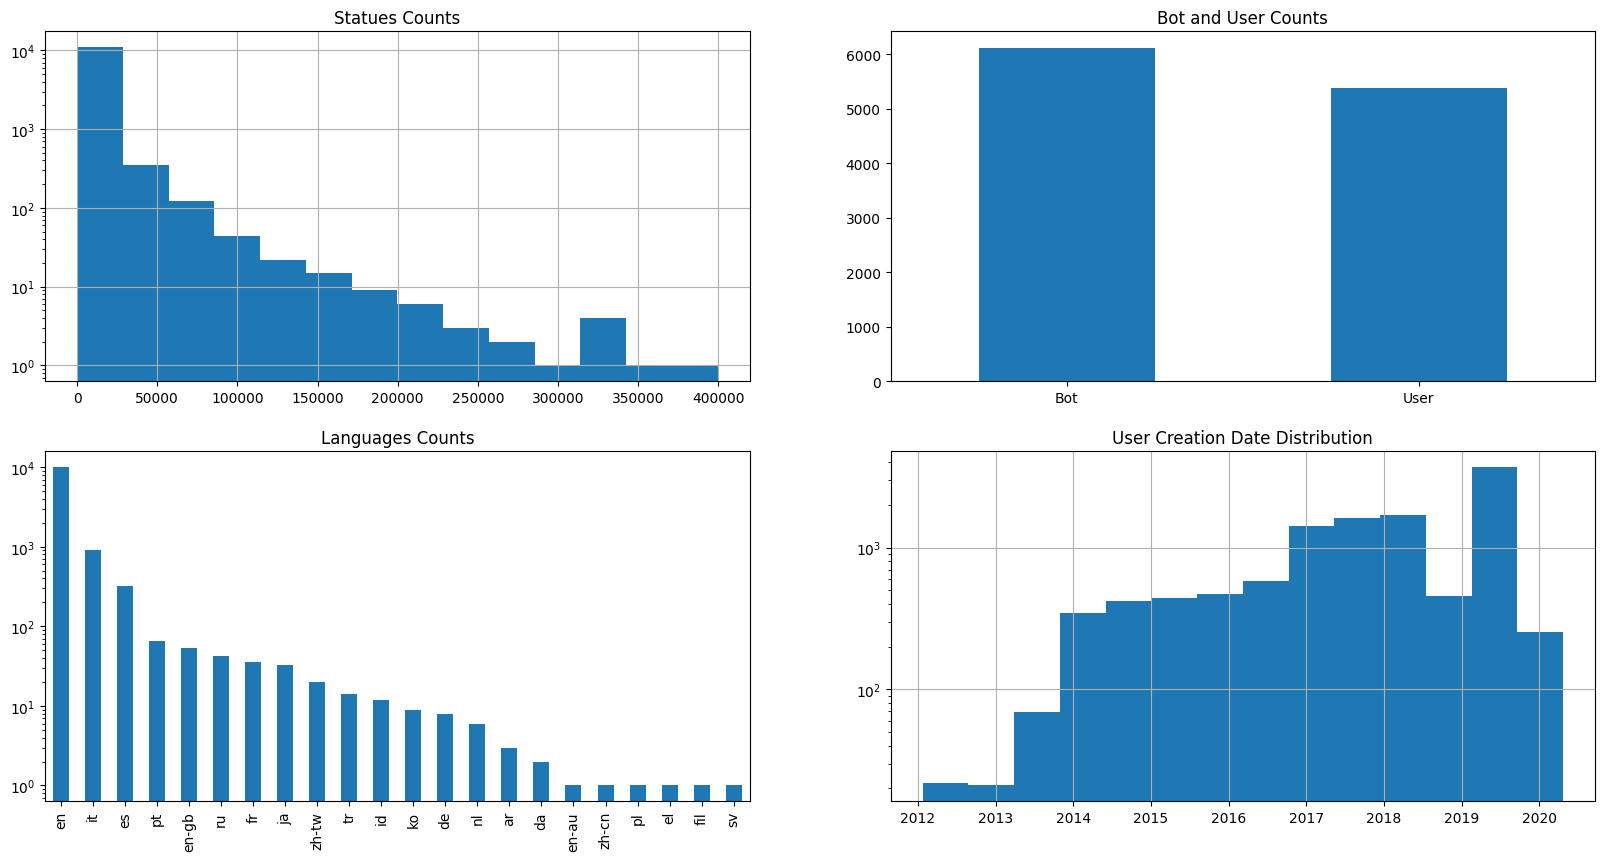

In [34]:
configs = [
    {
        'type': 'hist',
        'column': users['statuses_count'],
        'title': 'Statues Counts',
        'yscale': 'log',
    },
    {
        'type': 'bar',
        'column': users['bot'].map(lambda v: 'Bot' if v else 'User'),
        'title': 'Bot and User Counts',
        'rotation': True,
    },
    {
        'type': 'bar',
        'column': users['lang'],
        'title': 'Languages Counts',
        'yscale': 'log',
    },
    {
        'type': 'hist',
        'column': users['created_at'][users['created_at'] > pd.Timestamp(OUTLIER_TIMESTAMP)],
        'title': 'User Creation Date Distribution',
        'yscale': 'log',
    }
]

build_grid_plot(configs=configs)

Pie-plots of `bot` and `lang` columns of users dataset.

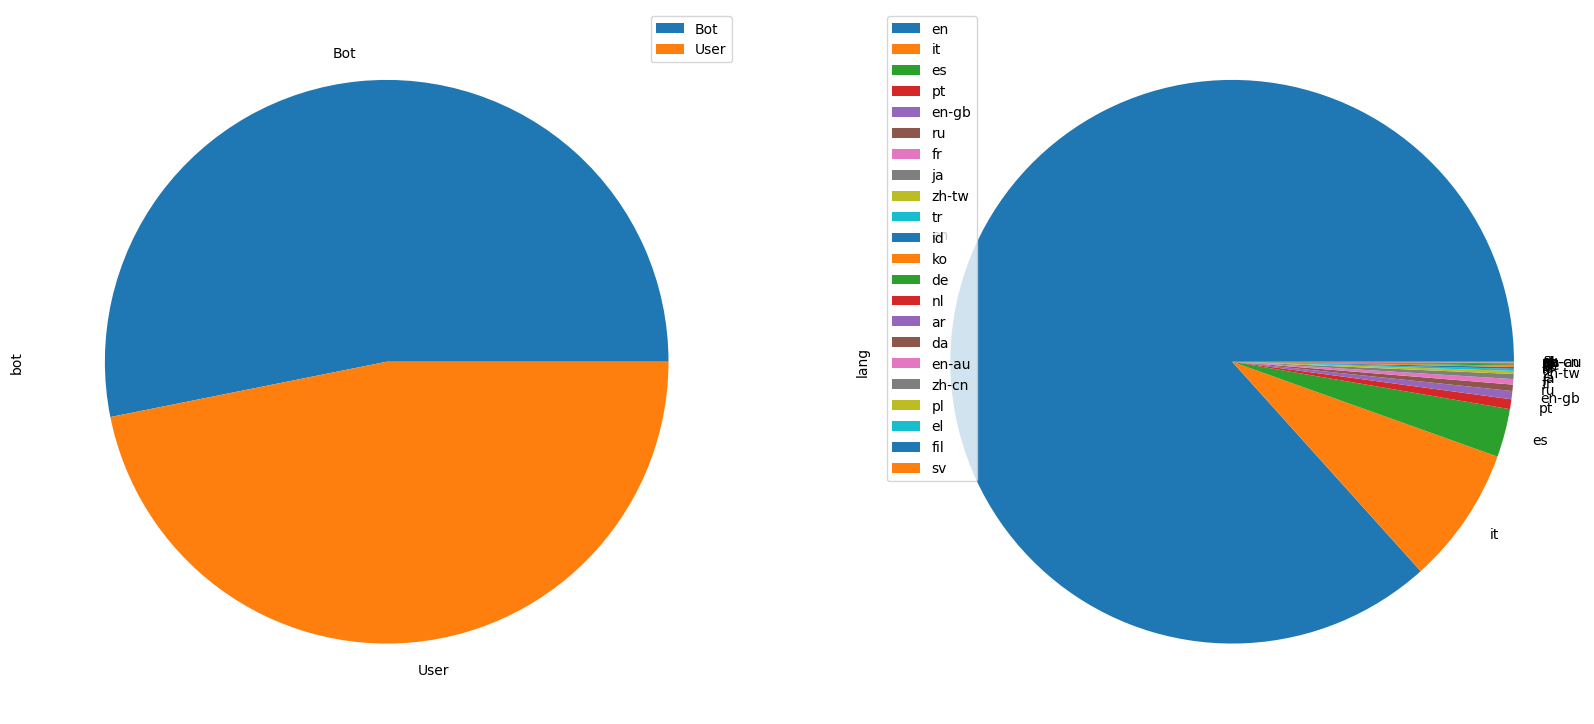

In [35]:
users_pie = users.copy()[['bot', 'lang']]
users_pie['bot'] = users_pie['bot'].map(lambda x: 'Bot' if x else 'User')

fig = plt.figure(figsize=(20, 100))
ax1 = fig.add_subplot(121)
users_pie['bot'].value_counts().plot.pie(legend=True, yticks=[])
ax2 = fig.add_subplot(122)
users_pie['lang'].value_counts().plot.pie(legend=True)
plt.show()

Tweets dataset histograms.

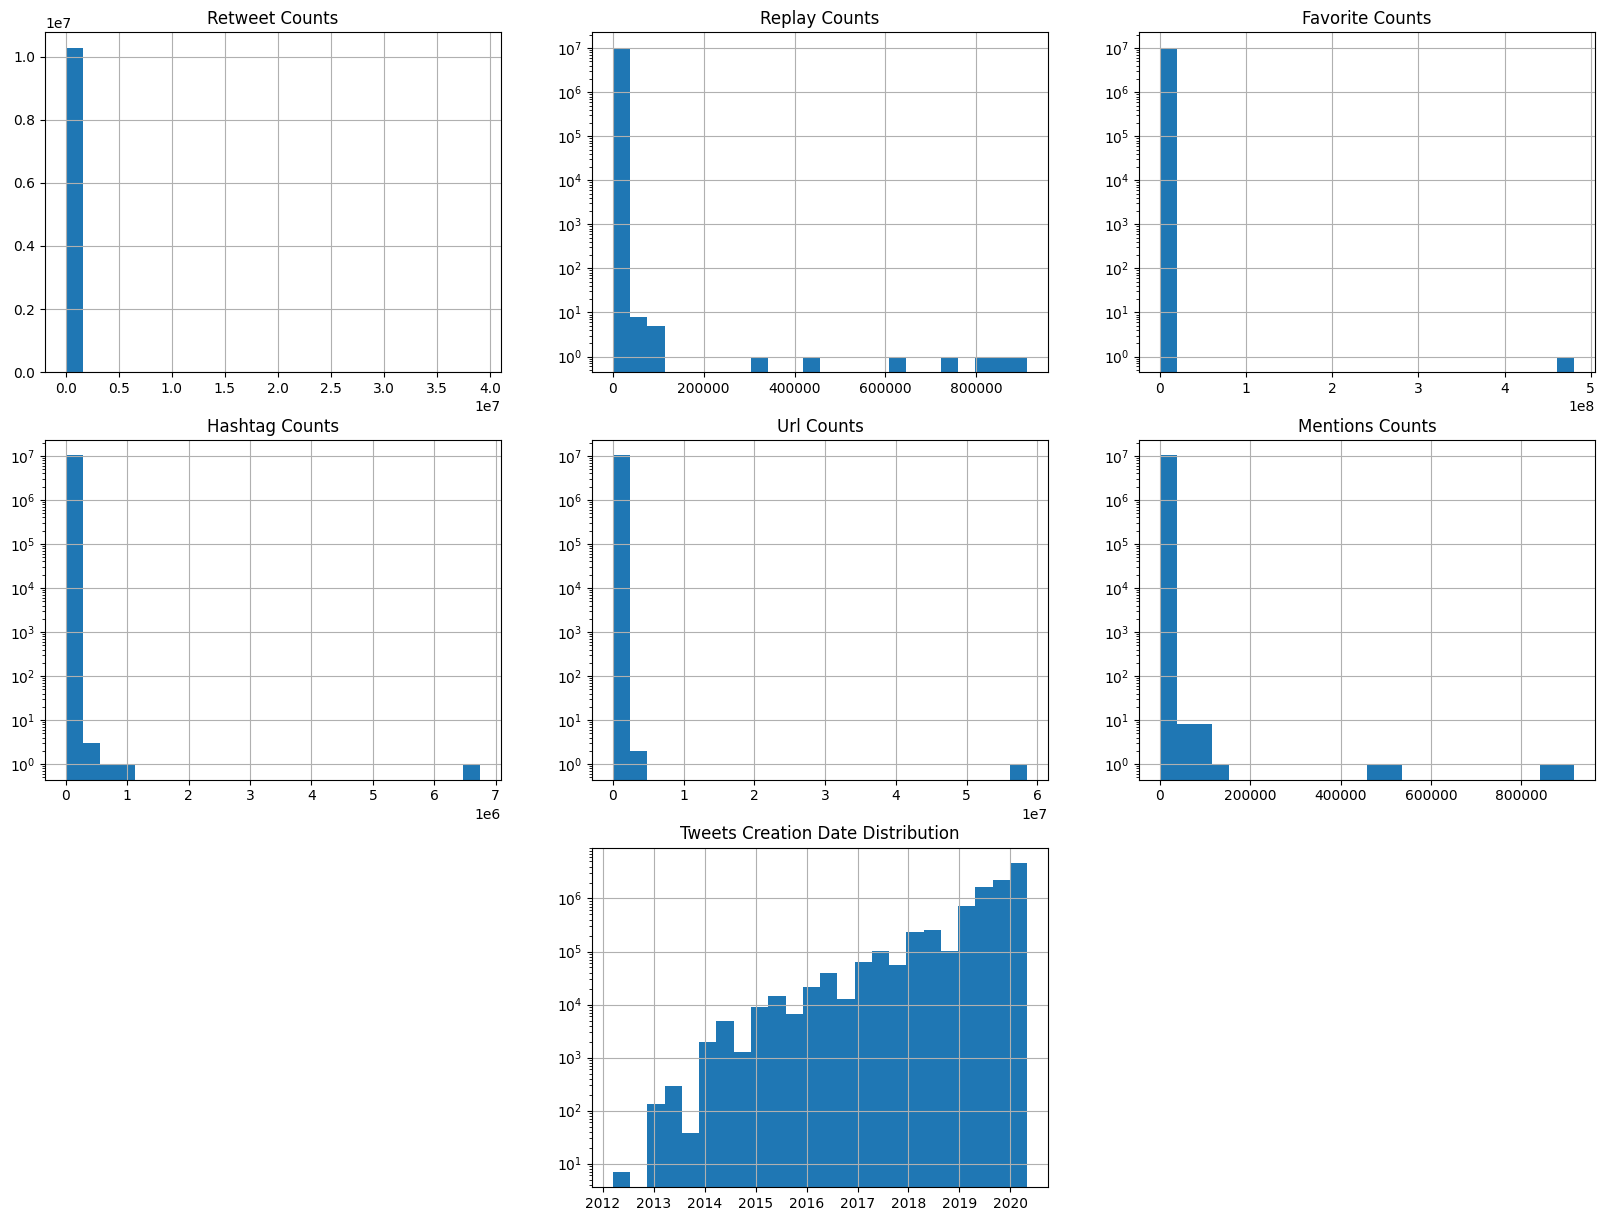

In [36]:
def plot_hist_tweets():
    configs = [
        {
            'type': 'hist',
            'column': tweets['retweet_count'],
            'title': 'Retweet Counts',
        },
        {
            'type': 'hist',
            'column': tweets['reply_count'],
            'title': 'Replay Counts',
            'yscale': 'log',
        },
        {
            'type': 'hist',
            'column': tweets['favorite_count'],
            'title': 'Favorite Counts',
            'yscale': 'log',
        },
        {
            'type': 'hist',
            'column': tweets['num_hashtags'],
            'title': 'Hashtag Counts',
            'yscale': 'log',
        },
        {
            'type': 'hist',
            'column': tweets['num_urls'],
            'title': 'Url Counts',
            'yscale': 'log',
        },
        {
            'type': 'hist',
            'column': tweets['num_mentions'],
            'title': 'Mentions Counts',
            'yscale': 'log',
        },
        {
            'type': 'hist',
            'column': tweets['created_at'][tweets['created_at'] > pd.Timestamp(OUTLIER_TIMESTAMP)],
            'title': 'Tweets Creation Date Distribution',
            'yscale': 'log',
        }
    ]

    build_grid_plot(configs=configs)

plot_hist_tweets()

In all numerical columns there are outliers to remove.

### Outlier detection

We plot box-plots and cut replace huge outliers.

`boxplot_tweets_show` is a function used to plot box-plots of tweets columns.

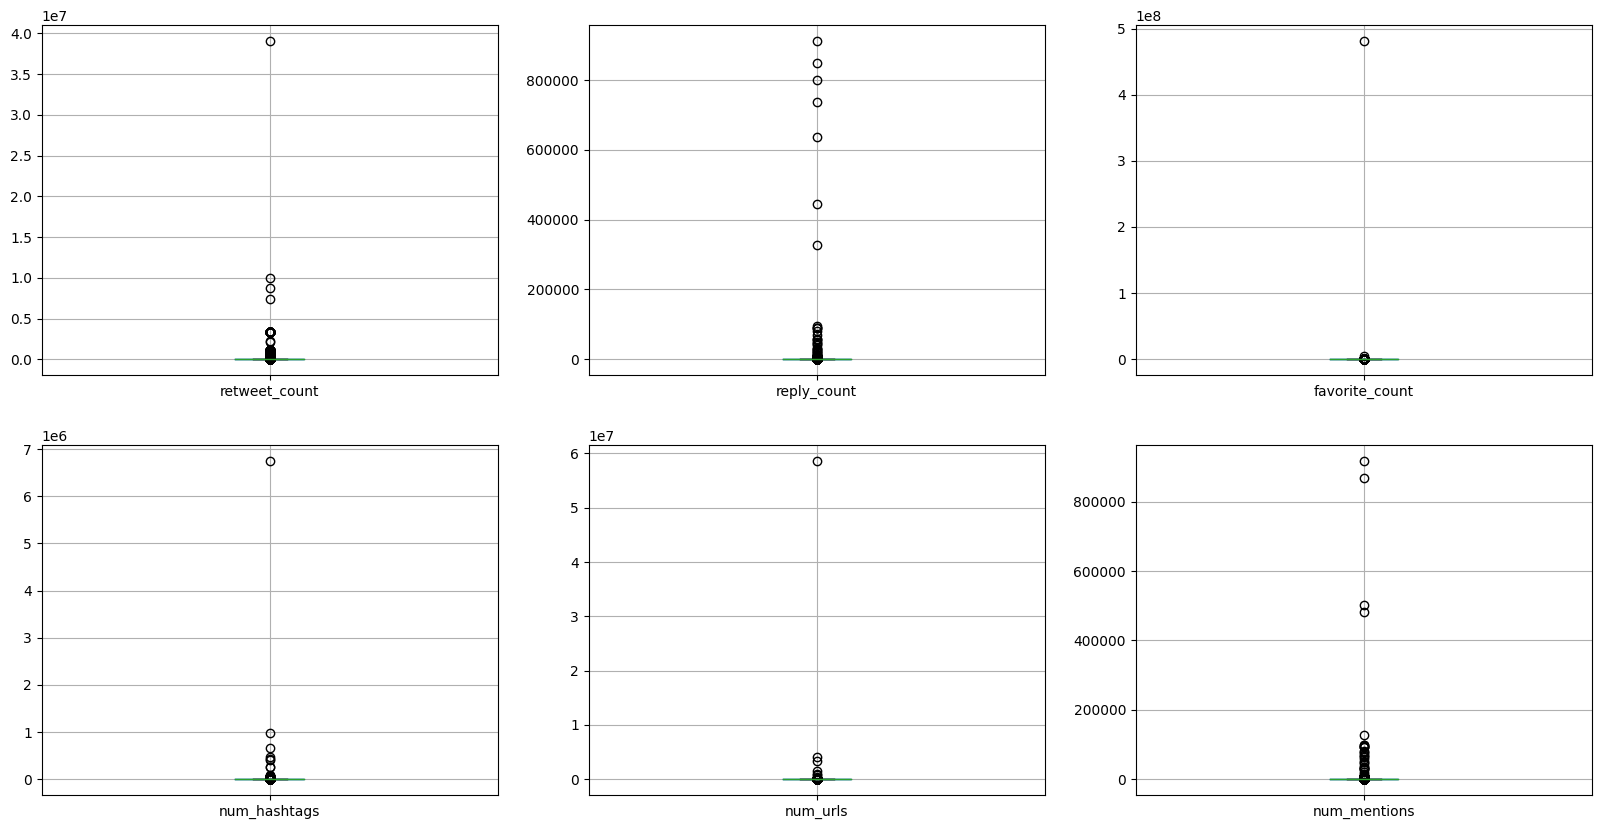

In [37]:
def boxplot_tweets_show(yscale='linear'):
    configs = [
        {
            'type': 'boxplot',
            'df': tweets,
            'columns': ['retweet_count'],
            'yscale': yscale,
        },
        {
            'type': 'boxplot',
            'df': tweets,
            'columns': ['reply_count'],
            'yscale': yscale,
        },
        {
            'type': 'boxplot',
            'df': tweets,
            'columns': ['favorite_count'],
            'yscale': yscale,
        },
        {
            'type': 'boxplot',
            'df': tweets,
            'columns': ['num_hashtags'],
            'yscale': yscale,
        },
        {
            'type': 'boxplot',
            'df': tweets,
            'columns': ['num_urls'],
            'yscale': yscale,
        },
        {
            'type': 'boxplot',
            'df': tweets,
            'columns': ['num_mentions'],
            'yscale': yscale,
        },
    ]

    build_grid_plot(configs=configs)

boxplot_tweets_show()

We show the percentage of outliers over the superior whisker of box-plot.

In [38]:
for col in ['retweet_count', 'reply_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions']:
    Q1 = np.quantile(tweets[col], 0.25)
    Q3 = np.quantile(tweets[col], 0.75)
    IQR = Q3 - Q1
    superior_whisker = Q3 + 1.5 * IQR
    outliers_perc = len(tweets[tweets[col] > superior_whisker]) / len(tweets) * 100
    lg.info(f'{outliers_perc} % of column {col} are over superior whisker that is {superior_whisker}')

2022-11-05 11:11:47,190 - root - INFO - 16.036753104357267 % of column retweet_count are over superior whisker that is 2.5
2022-11-05 11:11:47,305 - root - INFO - 0.17113449115832727 % of column reply_count are over superior whisker that is 0.0
2022-11-05 11:11:47,768 - root - INFO - 19.646249325129137 % of column favorite_count are over superior whisker that is 0.0
2022-11-05 11:11:48,134 - root - INFO - 11.305687986465863 % of column num_hashtags are over superior whisker that is 0.0
2022-11-05 11:11:48,555 - root - INFO - 16.03267198017996 % of column num_urls are over superior whisker that is 0.0
2022-11-05 11:11:48,779 - root - INFO - 2.2799166126007 % of column num_mentions are over superior whisker that is 2.5


Here we replace outlier values over a certain threshold with median.

2022-11-05 11:11:48,803 - root - INFO - 491 (0.004782415205392071%) element replaced for column retweet_count


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:11:53,868 - root - INFO - 31 (0.0003019447482019434%) element replaced for column reply_count


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:11:58,031 - root - INFO - 49 (0.00047726750522242663%) element replaced for column favorite_count


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:12:02,973 - root - INFO - 22 (0.00021428336969170177%) element replaced for column num_hashtags


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:12:06,971 - root - INFO - 21 (0.00020454321652389713%) element replaced for column num_urls


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


2022-11-05 11:12:11,850 - root - INFO - 30 (0.0002922045950341387%) element replaced for column num_mentions


/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


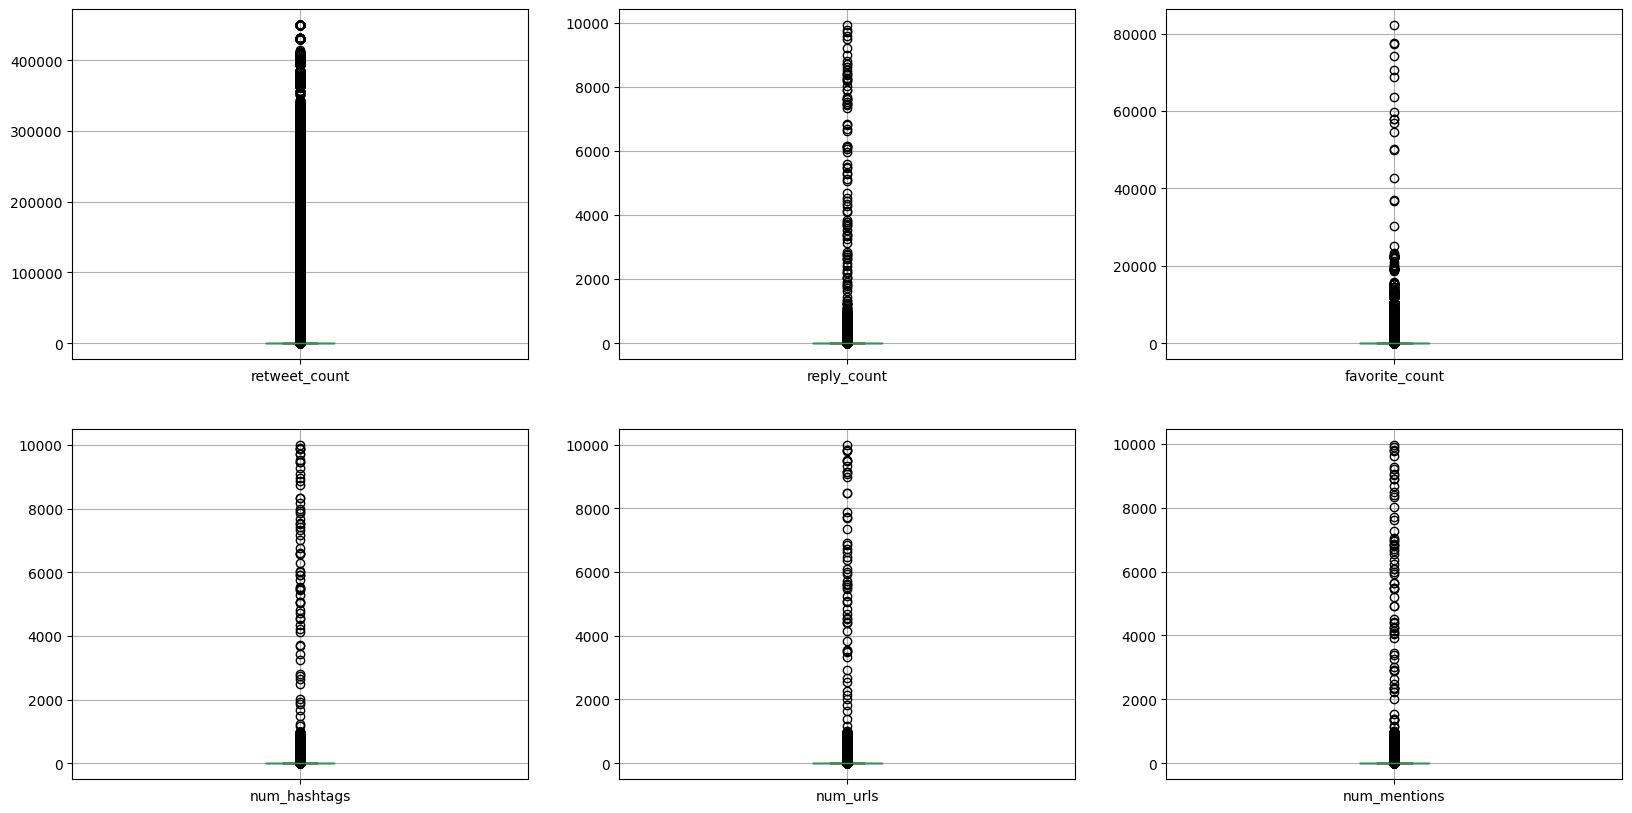

In [39]:
def replace_outliers(df, column_name, threshold):
    column = df[column_name]
    to_replace = len(column[column > threshold])
    perc_to_replace = to_replace / len(column) * 100
    lg.info(f'{to_replace} ({perc_to_replace}%) element replaced for column {column_name}')
    median = column.median()
    df[column_name] = column.parallel_map(lambda x: median if x > threshold else x)

replace_outliers(tweets, 'retweet_count', 4.5e5)
replace_outliers(tweets, 'reply_count', 1e4)
replace_outliers(tweets, 'favorite_count', 8.5e4)
replace_outliers(tweets, 'num_hashtags', 1e4)
replace_outliers(tweets, 'num_urls', 1e4)
replace_outliers(tweets, 'num_mentions', 1e4)

boxplot_tweets_show()

### Correlation

Users dataset correlation matrix.

In [40]:
users_num_cols = ['statuses_count', 'bot']
corr = users.corr(method='pearson', numeric_only=True).loc[users_num_cols, users_num_cols]
corr.style.background_gradient(cmap='coolwarm')

,statuses_count,bot
statuses_count,1.000000,-0.255156
bot,-0.255156,1.000000


Tweets dataset correlation matrix.

In [41]:
tweets_num_cols = ['retweet_count', 'reply_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions']
corr = tweets.corr(method='pearson', numeric_only=True).loc[tweets_num_cols, tweets_num_cols]
corr.style.background_gradient(cmap='coolwarm')

,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
retweet_count,1.000000,0.001338,0.010977,0.000073,-0.000374,0.002544
reply_count,0.001338,1.000000,0.017521,-0.000023,-0.000013,0.000003
favorite_count,0.010977,0.017521,1.000000,0.000285,0.000141,0.000263
num_hashtags,0.000073,-0.000023,0.000285,1.000000,0.000048,0.000119
num_urls,-0.000374,-0.000013,0.000141,0.000048,1.000000,-0.000110
num_mentions,0.002544,0.000003,0.000263,0.000119,-0.000110,1.000000


Scatterplot of tweets attributes with highest correlation to investigate their behavior.

<Figure size 2000x1000 with 0 Axes>

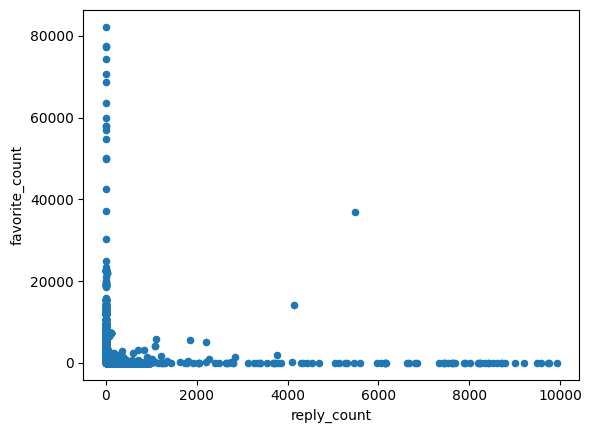

In [42]:
plt.figure(figsize=(20, 10))
tweets.plot.scatter(x='reply_count', y='favorite_count')
plt.show()

Principal Component Analysis on tweets dataset to investigate correlation between firsts two eigenvector that identifies main variability of tweets.

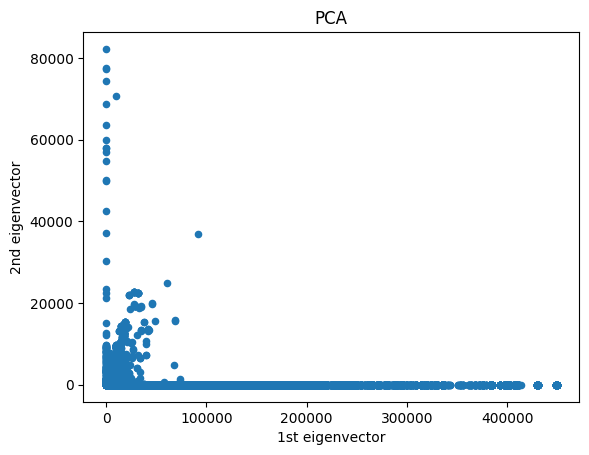

In [43]:
cat_tweets = tweets[tweets_num_cols]

ranked_coveriance_matrix = PCA(n_components=2).fit_transform(cat_tweets)
plt.scatter(ranked_coveriance_matrix[:, 0], ranked_coveriance_matrix[:, 1], s=20)
plt.title("PCA")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.show()

In [44]:
# save outlier_detection tweets and users as pickle
store_preprocessed_dataset(step_name="outlier_detection", file_name="tweets.pickle", df=tweets)
store_preprocessed_dataset(step_name="outlier_detection", file_name="users.pickle", df=users)